# ПРОДАЖИ КОНТРАГЕНТОВ

In [1]:
import itertools
import statsmodels.api as sm
import pandas as pd
from dataclasses import dataclass
import matplotlib.pyplot as plt
import warnings
import numpy as np

In [2]:
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings("ignore")
FONT_COLOR = "(0.8,0.8,0.8)"
BACKGROUND_COLOR = '(0.22, 0.22, 0.22)'
plt.rcParams['axes.facecolor'] = BACKGROUND_COLOR
plt.rcParams['figure.facecolor'] = BACKGROUND_COLOR
plt.rcParams['text.color'] = FONT_COLOR
plt.rcParams['axes.labelcolor'] = FONT_COLOR
plt.rcParams['xtick.color'] = FONT_COLOR
plt.rcParams['ytick.color'] = FONT_COLOR

In [3]:
sales = pd.read_excel('sales_by_dist.xlsx')

In [4]:
sales['Период'] = pd.to_datetime(sales['Период'], dayfirst=True)

In [5]:
sales.head()

,Контрагент,Номенклатура,Период,Количество
0,ПУЛЬС ХИМКИ,Аир корневища 75г,2017-01-01,4142
1,ПУЛЬС ХИМКИ,Аир корневища 75г,2017-02-01,7204
2,ПУЛЬС ХИМКИ,Аир корневища 75г,2017-03-01,6061
3,ПУЛЬС ХИМКИ,Аир корневища 75г,2017-04-01,3851
4,ПУЛЬС ХИМКИ,Аир корневища 75г,2017-05-01,3994


In [6]:
@dataclass
class SalesTimeSeries:
    data: pd.DataFrame
    distr: str
    aggregation: str
    start_date: str
    model: str = None
    predictions: float = None
    forecast: float = None

    def transform(self):
        if self.distr == 'All':
            self.data = self.data
        else:
            self.data = self.data[self.data['Контрагент'] == self.distr]
        self.data = self.data.set_index('Период')['Количество']
        self.data = self.data[self.data.index >= self.start_date]
        self.data = self.data.groupby(pd.Grouper(freq=self.aggregation)).sum()

    def train(self):
        p = d = q = range(0, 2)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

        res_aic = 9999
        arima_param = 0
        arima_param_seas = 0

        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(self.data,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
                    self.model = mod.fit()
                    if self.model.aic < res_aic:
                        res_aic = self.model.aic
                        arima_param = param
                        arima_param_seas = param_seasonal
                except:
                    continue

        mod = sm.tsa.statespace.SARIMAX(self.data,
                                        order=arima_param,
                                        seasonal_order=arima_param_seas,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        self.model = mod.fit()

    def predict(self):
        self.predictions = self.model.get_prediction(start=self.data.index[0]).predicted_mean

    def make_forecast(self):
        self.forecast = self.model.get_forecast(steps=12).predicted_mean

    def plot_time_series(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.data.index, self.data, marker='o', markersize=3, c='#7FFFD4')
        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.title(f"{self.distr} Time series plot")
        plt.grid(linestyle='--', c='grey')
        plt.tight_layout()
        plt.show()

    def plot_predictions(self):
        plt.figure(figsize=(8, 4))

        plt.plot(self.data.index, self.data, marker='o', markersize=3, c='#7FFFD4')
        plt.plot(self.predictions.index, self.predictions, marker='o', markersize=3, c='red')

        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.title(f"{self.distr} Actual vs predicted plot")
        plt.grid(linestyle='--', c='grey')
        plt.tight_layout()
        plt.show()

    def plot_forecast(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.forecast.index, self.forecast, marker='o', markersize=5, c='#7FFFD4', mfc='red')
        plt.xlabel('Date')
        plt.ylabel('Quantity')
        plt.title(f"{self.distr} Forecast plot", pad=20)
        plt.grid(linestyle='--', c='grey')
        plt.xticks(self.forecast.index, rotation=90)
        for x, y in zip(self.forecast.index, self.forecast):
            label = y
            plt.annotate(f"{round(label):,}", (x, y),
                         xycoords="data",
                         textcoords="offset points",
                         xytext=(0, 10), ha="center")
        plt.tight_layout()
        plt.show()

    def show_metrics(self):
        mape = np.mean(np.abs(self.predictions - self.data) / np.abs(self.data))
        me = np.mean(self.predictions - self.data)
        mae = np.mean(np.abs(self.predictions - self.data))
        mpe = np.mean((self.predictions - self.data) / self.data)
        rmse = np.mean((self.predictions - self.data) ** 2) ** .5
        corr = np.corrcoef(self.predictions, self.data)[0, 1]
        mins = np.amin(np.hstack([self.predictions[:, None],
                                  self.data[:, None]]), axis=1)
        maxs = np.amax(np.hstack([self.predictions[:, None],
                                  self.data[:, None]]), axis=1)
        minmax = 1 - np.mean(mins / maxs)

        metrics = {'mape': mape, 'me': me, 'mae': mae,
                   'mpe': mpe, 'rmse': rmse, 'corr': corr, 'minmax': minmax}
        print(metrics)

    def save_forecast(self):
        self.forecast.to_excel("forecast.xlsx")

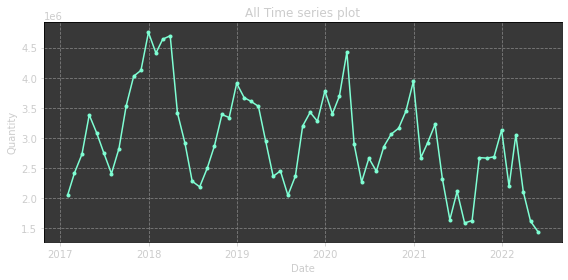

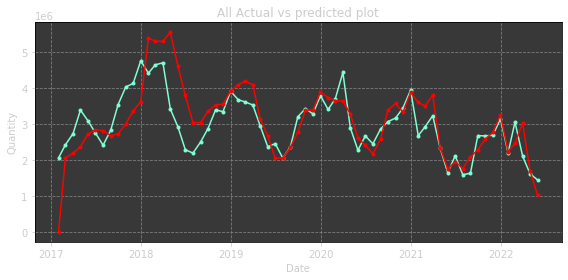

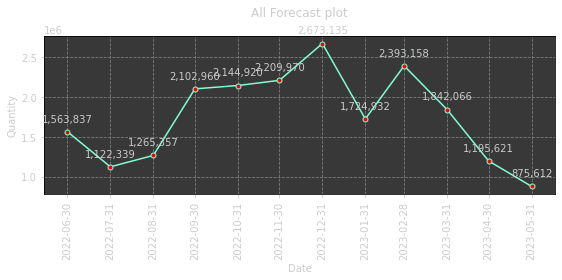

{'mape': 0.16651657325892547, 'me': 87395.13126994636, 'mae': 476668.63800063875, 'mpe': 0.03251711760696446, 'rmse': 661926.7284907269, 'corr': 0.7528192432554885, 'minmax': 0.14356205727177174}


In [7]:
data = SalesTimeSeries(data=sales, distr='All', aggregation='M', start_date='2017-01-01')
data.transform()
data.train()
data.predict()
data.make_forecast()
data.plot_time_series()
data.plot_predictions()
data.plot_forecast()
data.show_metrics()
data.save_forecast()

# ОБЪЕДИНЕНИЕ ДВУХ ТАБЛИЦ

In [16]:
production = pd.read_excel('2_stage_volume.xlsx')
sales_volume = pd.read_excel('sales_extend.xlsx')

In [17]:
production.head(1)

,По месяцам,Продукция,Количество,Цена
0,Январь 2012 г.,Фп Сб. Проктофитол (Противогеморроидальный сбо...,19836,6.0


In [18]:
sales_volume.head(1)

,По месяцам,Артикул,Номенклатура,Линия производства (св-во Номенклатура),Контрагент,Количество,Сумма продажи в руб.,"План, шт.","План, руб."
0,Январь 2012 г.,Т400438,"Фп Сб. Фитонефрол (Урологический сбор) 20x2,0г",Линия ИМА С 50,ОРИОЛА МОСКВА,12456,489558.16,NaN,NaN


In [19]:
production = production[production['По месяцам'] == 'Сентябрь 2022 г.']
sales_volume = sales_volume[sales_volume['По месяцам'] == 'Сентябрь 2022 г.']

In [20]:
production = production.groupby('Продукция').sum()['Количество'].reset_index()
sales_volume = sales_volume.groupby('Номенклатура').sum()['Количество'].reset_index()

In [25]:
final_tabel = production.merge(sales_volume[['Номенклатура', 'Количество']], left_on='Продукция', right_on='Номенклатура').drop('Номенклатура', axis=1).rename(columns={'Количество_x': 'Произведено', 'Количество_y': 'Продано'})

In [26]:
final_tabel

,Продукция,Произведено,Продано
0,Багульник болотный побеги 50г,9726,3500
1,Девясил корневища и корни 50г,21383,5236
2,Дуба кора 75г,83051,33026
3,Крапива листья 50г,17439,3766
4,Лен семена 100г,39728,7630
5,Мать-и-мачеха листья 35г,15242,5810
6,Подорожник большой листья 50г,7080,2268
7,Полынь горькая трава 50г,29620,13202
8,Ромашка цветки вн 50г,29492,32676
9,Сенна листья 50г,20128,7266


In [34]:
final_tabel_2 = sales_volume.merge(production[['Продукция', 'Количество']], left_on='Номенклатура', right_on='Продукция', how='left').drop('Продукция', axis=1).rename(columns={'Количество_x': 'Продано', 'Количество_y': 'Произведено'})

In [35]:
final_tabel_2

,Номенклатура,Продано,Произведено
0,Аир корневища 75г,2240,NaN
1,Алтей корни 75г,434,NaN
2,Багульник болотный побеги 50г,3500,9726.0
3,Береза почки 50г,1610,NaN
4,Бессмертник песчаный цветки 30г,7238,NaN
...,...,...,...
105,Чистотел трава 50г,4844,NaN
106,Шалфей листья 50г,11073,27460.0
107,Шиповник плоды низковитаминные 50г,5376,NaN
108,Эвкалипт прутовидный листья 75г,4634,NaN
